# Read in the route flows (aij matrix) or OD flows (P_mat)
### create plots of OD_flow vs time for selected OD relations
### create heatmaps of OD_flow vs. time
### calculate MSE of OD_Flow across models and/or vs. a reference. MLP 2 routes aij
### calculate MSE of calcualted counts vs. actual
### analysis of zero-flow edges vs. counters with counts: where, what systematic cause
### would an ensemble (mean, std dev/sqrt(N)) give a most likely best OD distribution?


In [1]:
import pandas as pd
import geopandas
import numpy as np
import cvxpy as cvx
import osmnx as osmnx
import networkx as nx
import matplotlib.pyplot as plt
import sklearn as sklearn

In [2]:
data_dir = "../UTD2019/"
counts_file = "utd19_u - Copy.csv"
detectors_file = "detectors_public - Copy.csv"
links_file = "links.csv"

In [3]:
city="melbourne"

# Output filenames are somewhat garbled.
# The first portion of the name is the name of the model.
### Aij and P_mat were calcualted for all models so the suffix "Aij" or "P_mat".npz means this matrix, regardless of the rest of the filename.
### Aij and P_mat only change if the number of routes changes so they are duplicated in the output
### _num means number of routes per OD relation

In [4]:
data=np.load(data_dir+"/OSM/"+city+"/Aij.npz")#MLP_aij_test_2_Aij
aij_2=data["aij"]
data=np.load(data_dir+"/OSM/"+city+"/AE_P_mat_test_1_Aij.npz")#
aij_1=data["aij"]
data=np.load(data_dir+"/OSM/"+city+"/Aij_5_route.npz")
aij_5=data["aij"]
data=np.load(data_dir+"/OSM/"+city+"/Aij_10_route.npz")#MLP_aij_test_10_Aij
aij_10=data["aij"]
data=np.load(data_dir+"/OSM/"+city+"/MLP_aij_test_25_Aij.npz")
aij_25=data["aij"]

### Aij matrix across different numbers of routes/OD

In [5]:
a_sparse_1=np.sum(aij_1)/(aij_1.size)
a_sparse_2=np.sum(aij_2)/(aij_2.size)
a_sparse_5=np.sum(aij_5)/(aij_5.size)
a_sparse_10=np.sum(aij_10)/(aij_10.size)
a_sparse_25=np.sum(aij_25)/(aij_25.size)

print("%5.3f,%5.3f,%5.3f,%5.3f,%5.3f" % (np.sum(aij_1)/(aij_1.size),np.sum(aij_2)/(aij_2.size),np.sum(aij_5)/(aij_5.size),np.sum(aij_10)/(aij_10.size),np.sum(aij_25)/(aij_25.size)))
print(aij_1.shape, aij_2.shape, aij_5.shape, aij_10.shape, aij_25.shape)

0.033,0.036,0.041,0.044,0.050
(67, 319) (67, 627) (67, 1545) (67, 3075) (67, 7665)


In [6]:
data=np.load(data_dir+"/OSM/"+city+"/AE_P_mat_test_1_P_mat.npz")#
P_mat_1=data["P_mat"]
data=np.load(data_dir+"/OSM/"+city+"/AE_aij_P_mat.npz")#
P_mat_2=data["P_mat"]
data=np.load(data_dir+"/OSM/"+city+"/P_mat_5_route.npz")
P_mat_5=data["P_mat"]
data=np.load(data_dir+"/OSM/"+city+"/AE_P_mat_test_10_P_mat.npz")#
P_mat_10=data["P_mat"]
data=np.load(data_dir+"/OSM/"+city+"/MLP_aij_test_25_P_mat.npz")
P_mat_25=data["P_mat"]

In [7]:
print("%5.3e,%5.3e,%5.3e,%5.3e,%5.3e" % (np.sum(P_mat_1)/(P_mat_1.size),np.sum(P_mat_2)/(P_mat_2.size),np.sum(P_mat_5)/(P_mat_5.size),np.sum(P_mat_10)/(P_mat_10.size),np.sum(P_mat_25)/(P_mat_25.size)))
print((np.sum(P_mat_1),np.sum(P_mat_2),np.sum(P_mat_5),np.sum(P_mat_10),np.sum(P_mat_25)))
print(P_mat_1.shape, P_mat_2.shape, P_mat_5.shape, P_mat_10.shape, P_mat_25.shape)

7.954e-04,5.622e-06,1.518e-11,1.277e-10,2.997e-23
(17.0, 0.1201559674534303, 3.2453726264380824e-07, 2.730041938345194e-06, 6.406400263126424e-19)
(67, 319) (67, 319) (67, 319) (67, 319) (67, 319)


### Open the od_pairs file (list)

In [8]:
import json
import pickle

with open(data_dir+"/OSM/"+city+"/od_pairs.pkl", 'rb') as f:
    od_pairs = pickle.load(f)

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_1.pkl", "rb") as f:
    od_route_names_dict_1=pickle.load(f)

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_2.pkl", "rb") as f:
    od_route_names_dict_2=pickle.load(f)

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_5.pkl", "rb") as f:
    od_route_names_dict_5=pickle.load(f)

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_10.pkl", "rb") as f:
    od_route_names_dict_10=pickle.load(f)

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_25.pkl", "rb") as f:
    od_route_names_dict_25=pickle.load(f)

In [9]:
# Make OD flows out of the route flows by summing over route flows for each OD

def od_flow_from_route_flow(od_pairs, route_flows,od_route_names_dict):
    
 # Make OD flows out of the route flows by summing over route flows for each OD
    I=route_flows.shape[1]
    J=len(od_pairs)
    j=0
    i_r=0
    od_flow=np.zeros((I))
    od_flow_matrix=np.zeros((J,I))
    for od in od_pairs:
        od_flow=0
        rs=od_route_names_dict[od]
        for r in rs:
            od_flow=od_flow+route_flows[i_r,:]
#            print(j,i_r,r,od_flow, route_flows[i_r,:])
            i_r+=1
        od_flow_matrix[j,:]=od_flow
        j+=1
    return(od_flow_matrix)

In [10]:
#RMSE
def rmse(y1,y2):
    return np.linalg.norm(y1 - y2) / np.sqrt(y1.size)
    

In [11]:
#RMSN
def rmsn(y1,y2):
    print("rmsn WARN may not be correct")
    return (np.linalg.norm(y1 - y2) / np.sqrt(y1.size))/np.mean(y1)
    

In [12]:
# MSE
def mse(y1,y2):
    return (np.square(y1 - y2)).mean()
    

In [13]:
# MAE
def mae(y1,y2):
    return (np.abs(y1-y2)).mean()

In [14]:
# MAPE
def mape(y1,y2):
    return (np.abs((y1-y2)/y1)).mean()

In [15]:
# MI
#
# For each time slice compare the distribution of flows across the OD relations
# Take the average in units of nats (sum of log base e)
#
def mi(y1,y2):
    mi=0
    for i in range(y1.shape[1]):
        mi+=sklearn.metrics.mutual_info_score(y1[:,i],y2[:,i])
    return mi/i

In [16]:
#zero
#
# The number of zeros in the od flow matrix
#
def zero(y):
    return (y.size-np.count_nonzero(y))/y.size

In [17]:
#odzero
#
# The number of OD relations with zeroes for all times
#
def odzero(y):
    xx=np.sum(y,axis=1)
    return zero(xx)

# The output (route or OD flows)

### Route flows

In [18]:
aijname_cpu=["route_flows_mcmc", "route_flows_cvxpy"]#npy
aijname_mlp=["MLP_aij_out","MLP_aij_cyclic_LR_out","MLP_aij_test_25_out","MLP_aij_cyclic_lr_1_route_out", "MLP_aij_cyclic_lr_5_route_out","MLP_aij_cyclic_lr_10_route_out",
"MLP_10_routes_cyclic_lr_out"]#npz
aijname_ae=["AE_aij_out","AE_aij_cyclic_lr_out","AE_aij_test_25_out"]#npz

In [19]:
data=np.load(data_dir+"/OSM/"+city+"/AE_aij_out.npz")
ytrain=data["ytrain"]
yval=data["yval"]
xyxy=data["out_val_cpu"]
mat=od_flow_from_route_flow(od_pairs,xyxy.T,od_route_names_dict_2)

In [20]:
xx=np.sum(mat,axis=1)
xx.shape

(319,)

### OD flows

In [21]:
pname_mlp=["MLP_P_mat_out",]#npz
pname_ae=["AE_P_mat_out","AE_P_mat_test_1_out","AE_P_mat_test_10_out"]#npz

In [22]:
mcmc_x=np.load(data_dir+"/OSM/"+city+"/"+aijname_cpu[0]+".npy")
cvxpy_x=np.load(data_dir+"/OSM/"+city+"/"+aijname_cpu[1]+".npy")

In [23]:
mcmc_od_flow=od_flow_from_route_flow(od_pairs,mcmc_x,od_route_names_dict_2)
mcmc_yval = aij_2 @ mcmc_x
cvxpy_od_flow=od_flow_from_route_flow(od_pairs,cvxpy_x,od_route_names_dict_2)
cvxpy_yval = aij_2 @ cvxpy_x

In [24]:
#
# Using MI with continuous variables warns us
#
import warnings
warnings.filterwarnings("ignore")

nroutes_od=[]
nroutes_od.append(2)# 2 routes per OD for mcmc
nroutes_od.append(2)# 2 routes per OD for cvxpy

asparse=[]
asparse.append(a_sparse_2)# 2 routes per OD for mcmc
asparse.append(a_sparse_2)# 2 routes per OD for cvxpy

RMSEy=[]
RMSEy.append(rmse(yval,mcmc_yval))
RMSEy.append(rmse(yval,cvxpy_yval))

RMSE=[]
RMSE.append(rmse(cvxpy_od_flow,mcmc_od_flow))
RMSE.append(rmse(cvxpy_od_flow,cvxpy_od_flow))

RMSN=[]
RMSN.append(rmsn(cvxpy_od_flow,mcmc_od_flow))
RMSN.append(rmsn(cvxpy_od_flow,cvxpy_od_flow))

MSE=[]
MSE.append(mse(cvxpy_od_flow,mcmc_od_flow))
MSE.append(mse(cvxpy_od_flow,cvxpy_od_flow))

MAE=[]
MAE.append(mae(cvxpy_od_flow,mcmc_od_flow))
MAE.append(mae(cvxpy_od_flow,cvxpy_od_flow))

MAPE=[]
MAPE.append(mape(cvxpy_od_flow,mcmc_od_flow))
MAPE.append(mape(cvxpy_od_flow,cvxpy_od_flow))

MI=[]
MI.append(mi(cvxpy_od_flow,mcmc_od_flow))
MI.append(mi(cvxpy_od_flow,cvxpy_od_flow))

MAX=[]
MAX.append(np.max(mcmc_od_flow))
MAX.append(np.max(cvxpy_od_flow))

MEAN=[]
MEAN.append(np.mean(mcmc_od_flow))
MEAN.append(np.mean(cvxpy_od_flow))

ZERO=[]
ZERO.append(zero(mcmc_od_flow))
ZERO.append(zero(cvxpy_od_flow))

ODZERO=[]
ODZERO.append(odzero(mcmc_od_flow))
ODZERO.append(odzero(cvxpy_od_flow))

rmsn WARN may not be correct
rmsn WARN may not be correct


# Load a model's output

In [25]:
# load the npz files
datalist=[]
for modelname in (aijname_mlp + aijname_ae):
    datalist.append(np.load(data_dir+"/OSM/"+city+"/"+modelname+".npz"))

In [26]:
for data in datalist:
    yhats_train=data["yhats_train"]
    yhats_val=data["yhats_val"]
    out_train_cpu=data["out_train_cpu"]
    out_val_cpu=data["out_val_cpu"]
    avtrainloss=data["avtrainloss_trace"]
    avvalloss=data["avvalloss_trace"]

    if(out_val_cpu.shape[1]/len(od_pairs)>20):
        od_flow_matrix=od_flow_from_route_flow(od_pairs,out_val_cpu.T,od_route_names_dict_25)
        nroutes_od.append(25)
        asparse.append(a_sparse_25)
    elif((out_val_cpu.shape[1]/len(od_pairs))>8):
        od_flow_matrix=od_flow_from_route_flow(od_pairs,out_val_cpu.T,od_route_names_dict_10)
        nroutes_od.append(10)
        asparse.append(a_sparse_10)
    elif((out_val_cpu.shape[1]/len(od_pairs))>3):
        od_flow_matrix=od_flow_from_route_flow(od_pairs,out_val_cpu.T,od_route_names_dict_5)
        nroutes_od.append(5)
        asparse.append(a_sparse_5)
    elif((out_val_cpu.shape[1]/len(od_pairs))>1.5):
        od_flow_matrix=od_flow_from_route_flow(od_pairs,out_val_cpu.T,od_route_names_dict_2)
        nroutes_od.append(2)
        asparse.append(a_sparse_2)
    else:
        od_flow_matrix=od_flow_from_route_flow(od_pairs,out_val_cpu.T,od_route_names_dict_1) 
        nroutes_od.append(1)
        asparse.append(a_sparse_1)
    RMSEy.append(rmse(yval,yhats_val.T))
    RMSE.append(rmse(cvxpy_od_flow,od_flow_matrix))
    RMSN.append(rmsn(cvxpy_od_flow,od_flow_matrix))
    MSE.append(mse(cvxpy_od_flow,od_flow_matrix))
    MAE.append(mae(cvxpy_od_flow,od_flow_matrix))
    MAPE.append(mape(cvxpy_od_flow,od_flow_matrix))
    MI.append(mi(cvxpy_od_flow,od_flow_matrix))
    MAX.append(np.max(od_flow_matrix))
    MEAN.append(np.mean(od_flow_matrix))
    ZERO.append(zero(od_flow_matrix))
    ODZERO.append(odzero(od_flow_matrix))

rmsn WARN may not be correct
rmsn WARN may not be correct
rmsn WARN may not be correct
rmsn WARN may not be correct
rmsn WARN may not be correct
rmsn WARN may not be correct
rmsn WARN may not be correct
rmsn WARN may not be correct
rmsn WARN may not be correct
rmsn WARN may not be correct


In [27]:
# load the npz files
datalist=[]
for modelname in (pname_mlp + pname_ae):
    datalist.append(np.load(data_dir+"/OSM/"+city+"/"+modelname+".npz"))

In [28]:
for data in datalist:
    yhats_train=data["yhats_train"]
    yhats_val=data["yhats_val"]
    out_train_cpu=data["out_train_cpu"]
    out_val_cpu=data["out_val_cpu"]
    avtrainloss=data["avtrainloss_trace"]
    avvalloss=data["avvalloss_trace"]

    od_flow_matrix=out_val_cpu.T
    

    RMSEy.append(rmse(yval,yhats_val.T))
    RMSE.append(rmse(cvxpy_od_flow,od_flow_matrix))
    RMSN.append(rmsn(cvxpy_od_flow,od_flow_matrix))
    MSE.append(mse(cvxpy_od_flow,od_flow_matrix))
    MAE.append(mae(cvxpy_od_flow,od_flow_matrix))
    MAPE.append(mape(cvxpy_od_flow,od_flow_matrix))
    MI.append(mi(cvxpy_od_flow,od_flow_matrix))
    MAX.append(np.max(od_flow_matrix))
    MEAN.append(np.mean(od_flow_matrix))
    ZERO.append(zero(od_flow_matrix))
    ODZERO.append(odzero(od_flow_matrix))
nroutes_od.append(2)# hard-code the number of routes per OD for the P_mat cases
nroutes_od.append(2)
nroutes_od.append(1)
nroutes_od.append(10)

rmsn WARN may not be correct
rmsn WARN may not be correct
rmsn WARN may not be correct
rmsn WARN may not be correct


In [29]:
df=pd.DataFrame()
df["modelname"]=aijname_cpu+aijname_mlp+aijname_ae+pname_mlp+pname_ae
df["nroutes"]=nroutes_od
df["rmsey"]=RMSEy
df["rmse"]=RMSE
df["rmsn"]=RMSN
df["mse"]=MSE
df["mae"]=MAE
df["mape"]=MAPE
df["mi"]=MI
df["max"]=MAX
df["mean"]=MEAN
df["zero"]=ZERO
df["odzero"]=ODZERO

In [30]:
mcmc_od_flow.shape

(319, 287)

In [31]:

pd.options.display.float_format = '{:,.2f}'.format
df

,modelname,nroutes,rmsey,rmse,rmsn,mse,mae,mape,mi,max,mean,zero,odzero
0,route_flows_mcmc,2,130.31,27.13,3.38,736.18,13.33,"1,051,292,323,578.77",2.55,607.00,13.79,0.00,0.00
1,route_flows_cvxpy,2,169.81,0.00,0.00,0.00,0.00,0.00,5.53,150.21,8.04,0.00,0.00
2,MLP_aij_out,2,136.07,23.10,2.87,533.71,12.68,"855,419,201,625.68",3.33,237.08,12.34,0.45,0.26
3,MLP_aij_cyclic_LR_out,2,128.45,28.21,3.51,796.06,13.27,"11,792,447,755.82",2.31,388.15,12.13,0.62,0.46
4,MLP_aij_test_25_out,25,101.32,31.01,3.86,961.91,14.83,"1,460,839,466,052.02",3.64,428.46,14.30,0.39,0.12
5,MLP_aij_cyclic_lr_1_route_out,1,149.49,27.30,3.40,745.47,13.07,"11,479,418,995.85",2.12,328.93,10.69,0.66,0.42
6,MLP_aij_cyclic_lr_5_route_out,5,111.75,31.07,3.87,965.37,14.57,"65,069,967,812.92",2.74,502.89,13.10,0.55,0.17
7,MLP_aij_cyclic_lr_10_route_out,10,105.06,30.42,3.78,925.18,13.86,"528,218,315,100.22",2.94,538.45,12.76,0.51,0.14
8,MLP_10_routes_cyclic_lr_out,10,104.12,30.71,3.82,942.96,14.05,"535,532,190,970.80",2.73,482.72,12.83,0.55,0.29
9,AE_aij_out,2,182.10,16.24,2.02,263.78,10.36,"390,196,202,615.14",4.36,83.68,8.40,0.27,0.21


Text(0.5, 1.0, ' RMSE of Generated and Actual counts vs. Num Routes per OD')

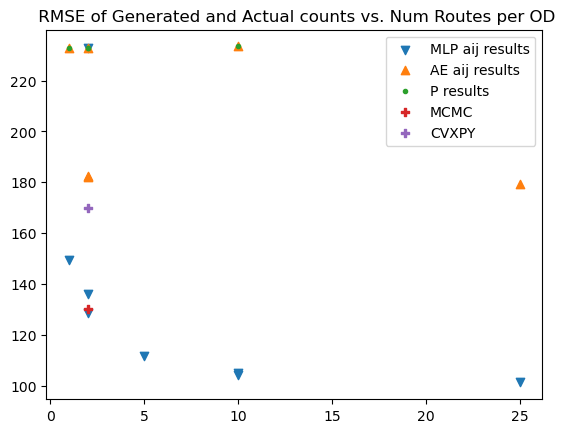

In [32]:
mlp_index=[2,3,4,5,6,7,8,12]
ae_index=[9,10,11,13,14,15]
p_index=[12,13,14,15]
plt.scatter(df.nroutes[mlp_index],df.rmsey[mlp_index], marker="v",label="MLP aij results")
plt.scatter(df.nroutes[ae_index],df.rmsey[ae_index],marker="^",label="AE aij results")
plt.scatter(df.nroutes[p_index],df.rmsey[p_index],marker=".",label="P results")
plt.scatter(df.nroutes[0],df.rmsey[0],marker="P",label="MCMC")
plt.scatter(df.nroutes[1],df.rmsey[1],marker="P",label="CVXPY")
plt.legend()
plt.title(" RMSE of Generated and Actual counts vs. Num Routes per OD")

Text(0.5, 1.0, 'Proportion of OD relations (319) with zero traffic vs. Num Routes per OD')

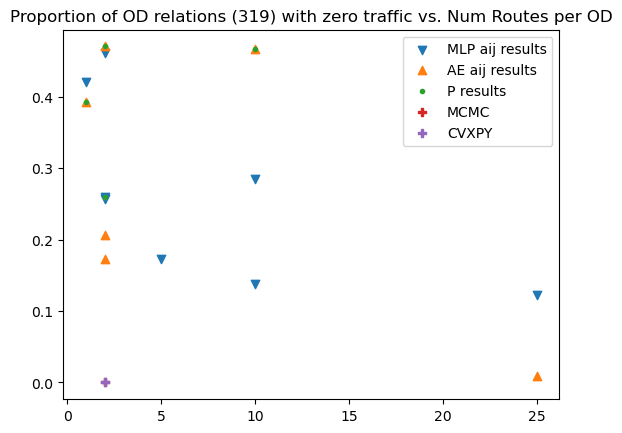

In [33]:
mlp_index=[2,3,4,5,6,7,8,12]
ae_index=[9,10,11,13,14,15]
p_index=[12,13,14,15]
plt.scatter(df.nroutes[mlp_index],df.odzero[mlp_index], marker="v",label="MLP aij results")
plt.scatter(df.nroutes[ae_index],df.odzero[ae_index],marker="^",label="AE aij results")
plt.scatter(df.nroutes[p_index],df.odzero[p_index],marker=".",label="P results")
plt.scatter(df.nroutes[0],df.odzero[0],marker="P",label="MCMC")
plt.scatter(df.nroutes[1],df.odzero[1],marker="P",label="CVXPY")
plt.legend()
plt.title("Proportion of OD relations (319) with zero traffic vs. Num Routes per OD")